# Exercício MNIST com várias camadas (Respostas)|

O objetivo deste notebook é treinar uma rede com várias camadas para o dataset MNIST. Para isso complete as partes de código sinalizadas que estão faltando.

## Importação das bibliotecas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

## Funções de predição e acurácia

In [2]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

def getAccuracy(model, inputs, targets):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    predicts = predicts.data.numpy()
    targets  = targets.numpy()

    accuracy = (predicts == targets).mean()
    return accuracy

## Carregamento dos dados do MNIST

In [3]:
dataset_dir = '/data/datasets/MNIST/'

# Transformara os dados em tensores no intervalo [0.0, 1.0] (Os dados serão normalizados)
data_transform = transforms.ToTensor()

# carrega o conjunto de treinamento e de teste
train_dataset = MNIST(dataset_dir, train=True,  transform=data_transform)
test_dataset  = MNIST(dataset_dir, train=False, transform=data_transform)

print("Tamanho do dataset de treino:", len(train_dataset))
print("Tamanho do dataset de teste: ", len(test_dataset))

print("\nDimensões dos dados das imagens:", train_dataset[0][0].size())
print("Tipo dos dados das imagens:     ", type(train_dataset[0][0]))
print("Tipo das classes das imagens:   ", type(train_dataset[0][1]))

Tamanho do dataset de treino: 60000
Tamanho do dataset de teste:  10000

Dimensões dos dados das imagens: torch.Size([1, 28, 28])
Tipo dos dados das imagens:      <class 'torch.FloatTensor'>
Tipo das classes das imagens:    <class 'int'>


## Organizando e normalizando os dados

Neste exemplo utilizaremos 500 amostras de treinamento e 100 amostras para testes.


In [4]:
n_samples_train = 1000
n_samples_test  = 500

train_dataset.train_data   = train_dataset.train_data[:n_samples_train]
train_dataset.train_labels = train_dataset.train_labels[:n_samples_train]
test_dataset.test_data   = test_dataset.test_data[:n_samples_test]
test_dataset.test_labels = test_dataset.test_labels[:n_samples_test]

print('Amostras para treinamento:', len(train_dataset))
print('Amostras para validação:',   len(test_dataset))

Amostras para treinamento: 1000
Amostras para validação: 500


## Visualizando os dados

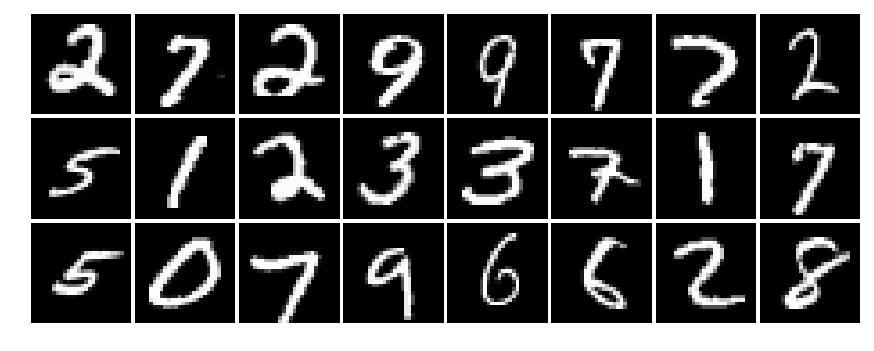

In [5]:
n_samples = 24

# cria um DataLoader temporario para pegar um batch de 'n_samples' imagens de treinamento
temp_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=n_samples,
                                              shuffle=True)

# pega um batch de imagens
image_batch, labels = next(iter(temp_dataloader))

# cria um grid com as imagens
grid = torchvision.utils.make_grid(image_batch, normalize=True, pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

## Treinamento

### Exercício 1 - Criação dos DataLoaders

In [6]:
# Cria um DataLoader de somente um batch
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=64,#len(train_dataset),
                                               shuffle=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=len(test_dataset),
                                              shuffle=False)

In [7]:
# verificação do exercício 1
if len(train_dataloader) > 1:
    print('train_dataloader tem mais de 1 batch')
else:
    print('train_dataloader está correto')
    
if len(test_dataloader) > 1:
    print('train_dataloader tem mais de 1 batch')
else:
    print('train_dataloader está correto')

train_dataloader tem mais de 1 batch
train_dataloader está correto


### Exercício 2 - Complete a criação da rede

In [8]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
        )
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.dense(x)
        
        return x
    
model = Modelo()
print(model)

Modelo (
  (dense): Sequential (
    (0): Linear (784 -> 50)
    (1): ReLU ()
    (2): Linear (50 -> 10)
  )
)


In [9]:
#Verificação do exercicio 2
test_input  = torch.FloatTensor(3, 28, 28)  # 3 amostras aleatórias para teste
test_output = model(Variable(test_input))

if test_output.size(1) == 10 and test_output.size(0) == test_input.size(0):
    print('Rede está funcionando corretamente')
elif test_output.size(1) != 10:
    print('Saída da rede deve ter dimensão (n_amostras, 10), mas tem dimensão ({}, {})'.format(
        test_output.size(0), test_output.size(0)))
elif test_output.size(0) != test_input.size(0):
    print('Número de amostras na saída ({}) deve ser igual ao da entrada ({})'.format(
        test_output.size(0), test_input.size(0)))

Rede está funcionando corretamente


### Inicialização dos parâmetros

In [10]:
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Nosso otomizador será SDG
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Laço de treinamento dos pesos

In [11]:
epochs = 100

# Pega todas as imagens de uma vez
#inputs, targets = next(iter(train_dataloader))
# Transforma em vetor

losses = []
for epoch in range(epochs):
    for inputs,targets in train_dataloader:
        inputs = inputs.view(-1, 28*28)
        # predict - forward
        output = model(Variable(inputs))

        # calcula a perda
        loss = criterion(output, Variable(targets))

        # Zero, backpropag gradientes, ajusta parâmetros gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(loss.data[0])
    
print('Final loss:', loss.data[0])

Final loss: 0.0015047878259792924


## Visualizando gráfico de perda durante o treinamento

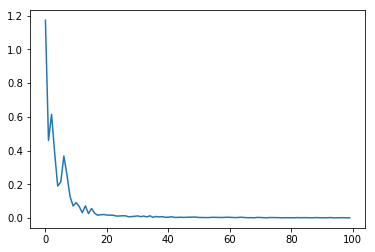

In [12]:
plt.plot(losses)

## Avaliando a acurácia tanto no conjunto de treinamento como no conjunto de testes

In [13]:
print('Training Accuracy: ', getAccuracy(model, inputs, targets))

test_input, test_labels = next(iter(test_dataloader))
print('Test Accuracy: ', getAccuracy(model, test_input, test_labels))

Training Accuracy:  1.0
Test Accuracy:  0.876


## Matriz de confusão com dados de treinamento e teste

In [14]:
print('Matriz de confusão (Treino):')
display(pd.crosstab(predict(model, inputs), targets.numpy()))

print('Matriz de confusão (Teste):')
display(pd.crosstab(predict(model, test_input), test_labels.numpy()))

Matriz de confusão (Treino):


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,3,0,0,0,0,0,0,0,0,0
1,0,6,0,0,0,0,0,0,0,0
2,0,0,3,0,0,0,0,0,0,0
3,0,0,0,2,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,5,0,0,0,0
6,0,0,0,0,0,0,3,0,0,0
7,0,0,0,0,0,0,0,8,0,0
8,0,0,0,0,0,0,0,0,4,0


Matriz de confusão (Teste):


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,41,0,0,0,0,1,1,0,1,0
1,0,67,0,0,0,0,0,0,0,0
2,0,0,48,2,0,0,2,1,1,0
3,1,0,2,34,0,0,0,2,0,2
4,0,0,1,0,51,1,0,1,1,0
5,0,0,0,8,0,40,3,0,1,2
6,0,0,0,0,1,2,37,0,0,0
7,0,0,3,1,0,1,0,43,2,4
8,0,0,1,0,0,3,0,0,32,1


## Conclusões sobre os experimentos deste notebook
